<a href="https://colab.research.google.com/github/addy4/battery-performance-simulation/blob/main/perfomance_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Battery perfomance simulation based on hybrid approach of
1. Mathematical Model (Based on Electrochemical Nature of Cell)
2. Neural-Networks (Based on Data consisting of battery's state parameters)

For this PoC, we have considered a Lithium-IoN battery which is used extensively in Electric Vehicles.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [3]:
from google.colab import files
data_to_load = files.upload()

Saving discharge.csv to discharge.csv


In [4]:
import io
df2 = pd.read_csv(io.BytesIO(data_to_load['discharge.csv']))

In [5]:
df2.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Battery
0,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,discharge,24,2008.0,B0005
1,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,discharge,24,2008.0,B0005
2,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,discharge,24,2008.0,B0005
3,3.920058,-2.013007,24.909816,1.9982,2.991,90.094,1.856487,1,discharge,24,2008.0,B0005
4,3.907904,-2.014400,25.105884,1.9982,2.977,108.281,1.856487,1,discharge,24,2008.0,B0005


Visual representation of data to show unique values type, battery and temperature

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

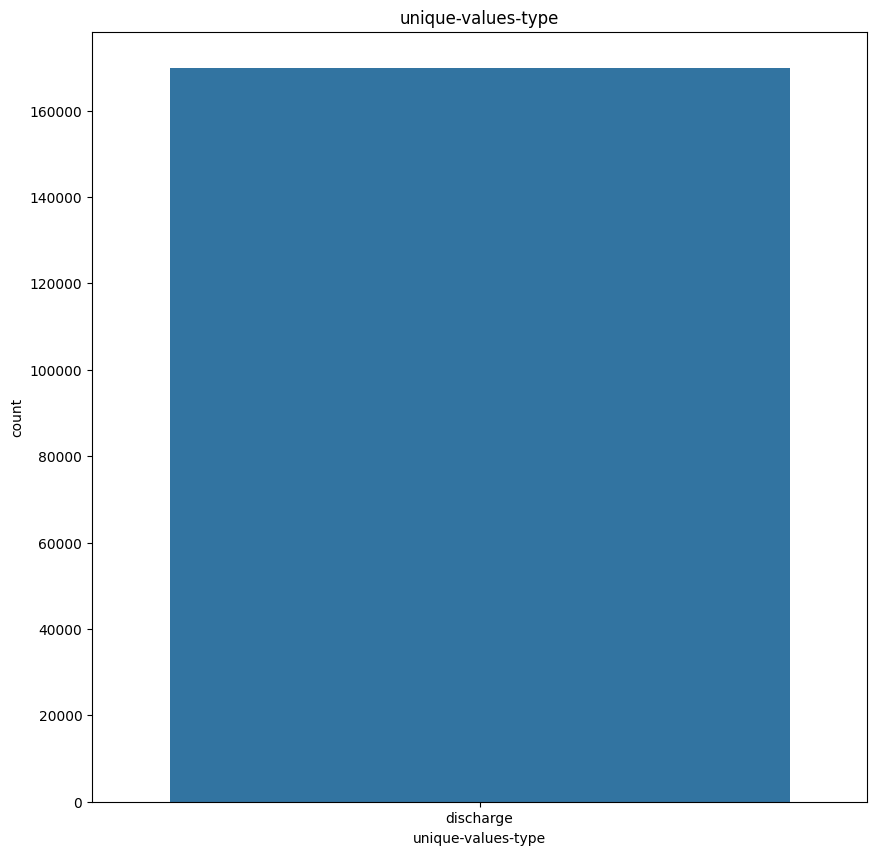

In [30]:
# Get unique values and their counts (type)
value_counts = df2['type'].value_counts().reset_index()
value_counts.columns = ['unique-values-type', 'count']

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='unique-values-type', y='count', data=value_counts)
plt.xlabel('unique-values-type')
plt.ylabel('count')
plt.title('unique-values-type')
plt.show()

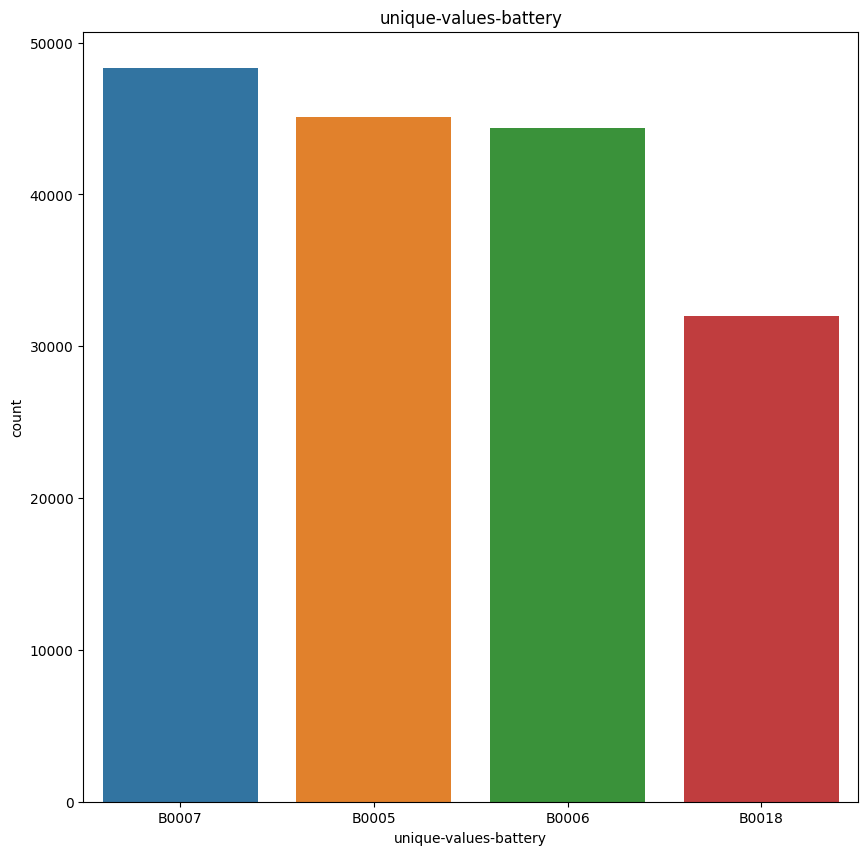

In [32]:
# Get unique values and their counts (battery)
value_counts = df2['Battery'].value_counts().reset_index()
value_counts.columns = ['unique-values-battery', 'count']

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='unique-values-battery', y='count', data=value_counts)
plt.xlabel('unique-values-battery')
plt.ylabel('count')
plt.title('unique-values-battery')
plt.show()

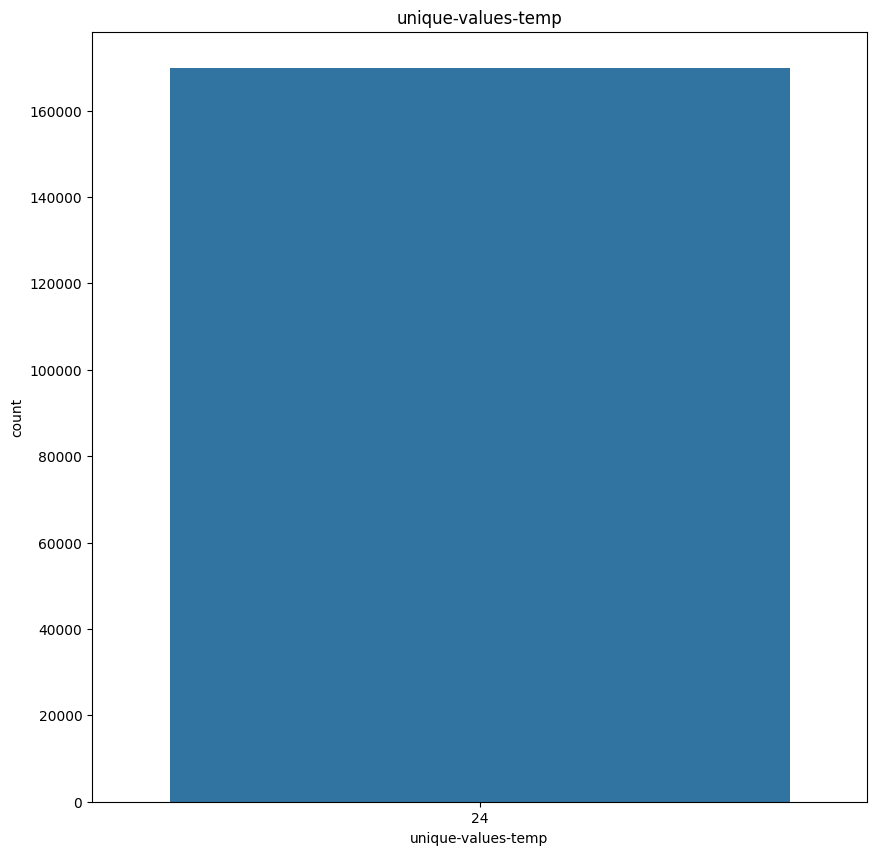

In [34]:
# Get unique values and their counts (temp.)
value_counts = df2['ambient_temperature'].value_counts().reset_index()
value_counts.columns = ['unique-values-temp', 'count']

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='unique-values-temp', y='count', data=value_counts)
plt.xlabel('unique-values-temp')
plt.ylabel('count')
plt.title('unique-values-temp')
plt.show()

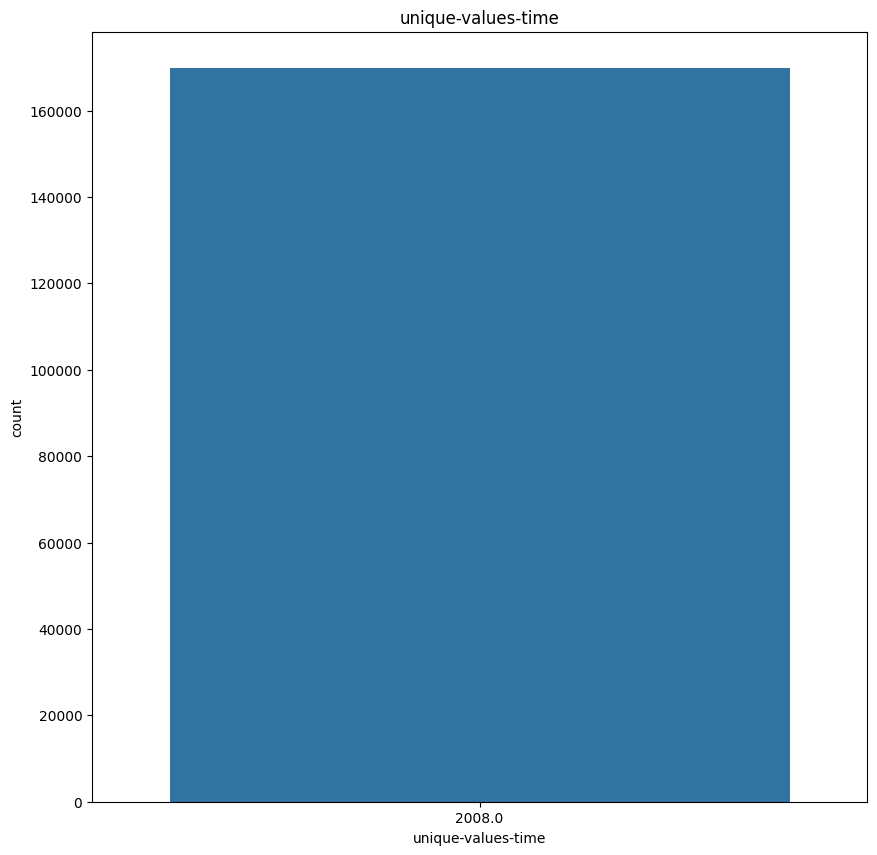

In [37]:
# Get unique values and their counts (time)
value_counts = df2['time'].value_counts().reset_index()
value_counts.columns = ['unique-values-time', 'count']

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='unique-values-time', y='count', data=value_counts)
plt.xlabel('unique-values-time')
plt.ylabel('count')
plt.title('unique-values-time')
plt.show()